<a href="https://colab.research.google.com/github/ashwami30/Applied-ML-project/blob/main/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 3.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=23044ff58840f9399b9a181ee4f9c0bfb23b5c77076636bd11260dd947f527ed
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 730 kB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 145 kB 35.9 MB/s 
     |████████████████████████████████| 130 kB 50.7 MB/s 
     |████████████████████████████████| 843 kB 46.4 MB/s 
     |███████████████████████████████

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "ashwamidalvi" 
os.environ['KAGGLE_KEY'] = "6b2f39f9b578e6179caee08cdb634ed1"

In [3]:
!kaggle datasets download -d tannergi/chess-piece-detection

 99% 164M/166M [00:02<00:00, 71.5MB/s]
100% 166M/166M [00:02<00:00, 62.7MB/s]


In [4]:
!unzip chess-piece-detection.zip

Archive:  chess-piece-detection.zip
  inflating: Chess Detection/annotations/IMG_1989.xml  
  inflating: Chess Detection/annotations/IMG_1990.xml  
  inflating: Chess Detection/annotations/IMG_1991.xml  
  inflating: Chess Detection/annotations/IMG_1992.xml  
  inflating: Chess Detection/annotations/IMG_1993.xml  
  inflating: Chess Detection/annotations/IMG_1994.xml  
  inflating: Chess Detection/annotations/IMG_1995.xml  
  inflating: Chess Detection/annotations/IMG_1996.xml  
  inflating: Chess Detection/annotations/IMG_1997.xml  
  inflating: Chess Detection/annotations/IMG_1998.xml  
  inflating: Chess Detection/annotations/IMG_1999.xml  
  inflating: Chess Detection/annotations/IMG_2000.xml  
  inflating: Chess Detection/annotations/IMG_2001.xml  
  inflating: Chess Detection/annotations/IMG_2002.xml  
  inflating: Chess Detection/annotations/IMG_2003.xml  
  inflating: Chess Detection/annotations/IMG_2004.xml  
  inflating: Chess Detection/annotations/IMG_2005.xml  
  inflating:

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
import xml.etree.ElementTree as ET


# write a function that loads the dataset into detectron2's standard format
def get_dataset_dicts(annotation_path, image_path):
    classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

    dataset_dicts = []
    for idx, filename in enumerate(os.listdir(annotation_path)):
        record = {}
        root = ET.parse(os.path.join(annotation_path, filename)).getroot()
        record["file_name"] = os.path.join(image_path, root.find('filename').text)
        record["height"] = 2248
        record["width"] = 4000

        objs = []
        for member in root.findall('object'):
          obj = {
              'bbox': [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text), int(member[4][3].text)],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': classes.index(member[0].text),
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [6]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['white-rook', 'white-knight', 'white-bishop', 'white-king', 'white-queen', 'white-pawn', 'black-rook', 'black-knight', 'black-bishop', 'black-king', 'black-queen', 'black-pawn']

DatasetCatalog.register('chess_piece_dataset', lambda: get_dataset_dicts('Chess Detection/annotations', 'Chess Detection/images'))
MetadataCatalog.get('chess_piece_dataset').set(thing_classes=classes)
chess_metadata = MetadataCatalog.get('chess_piece_dataset')

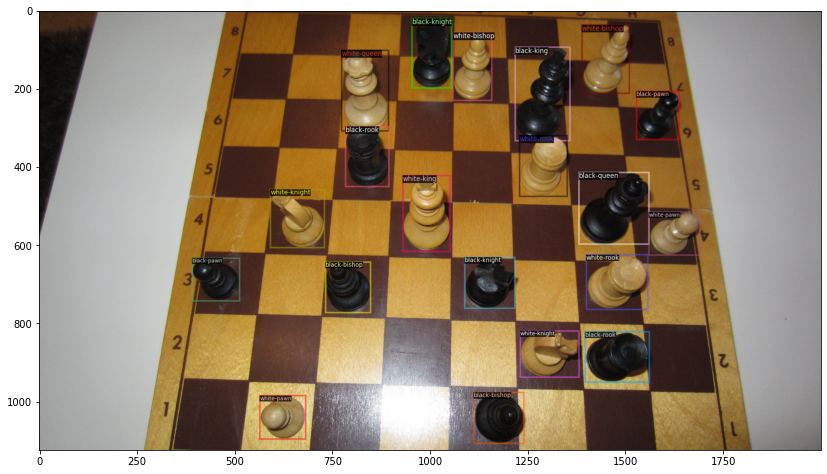

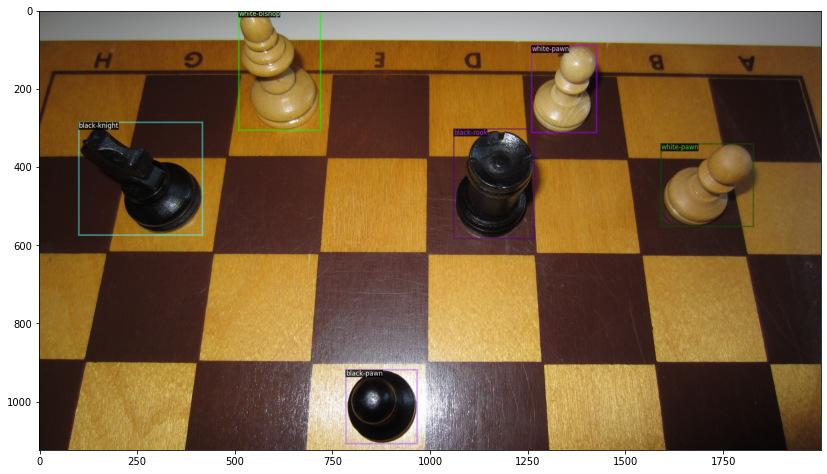

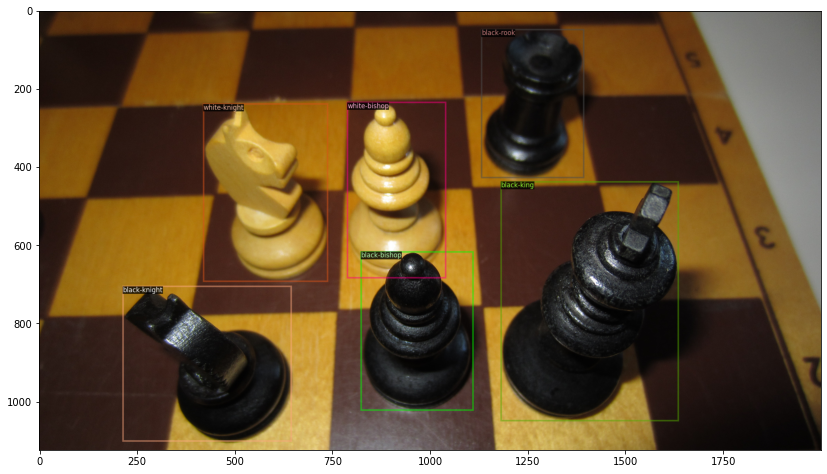

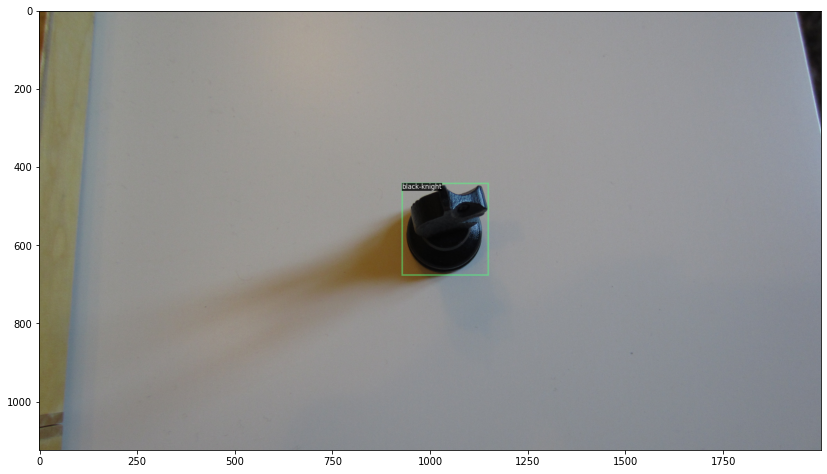

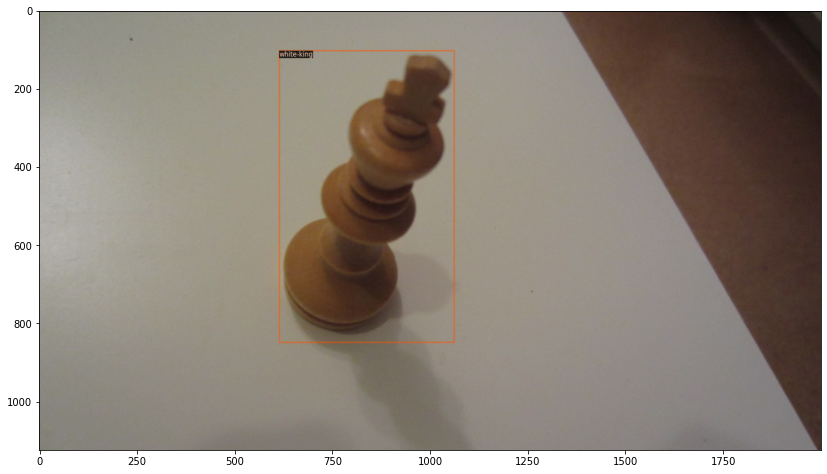

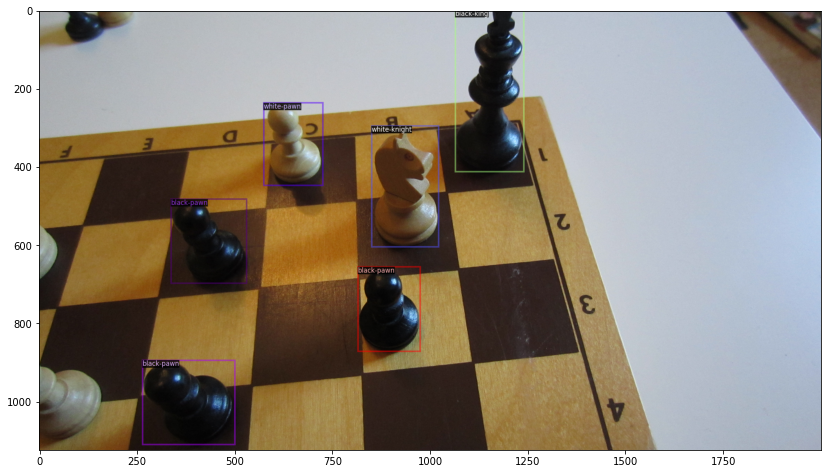

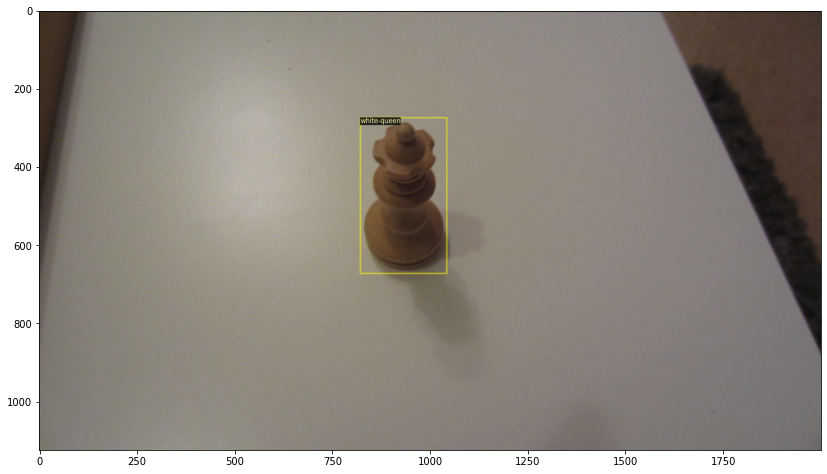

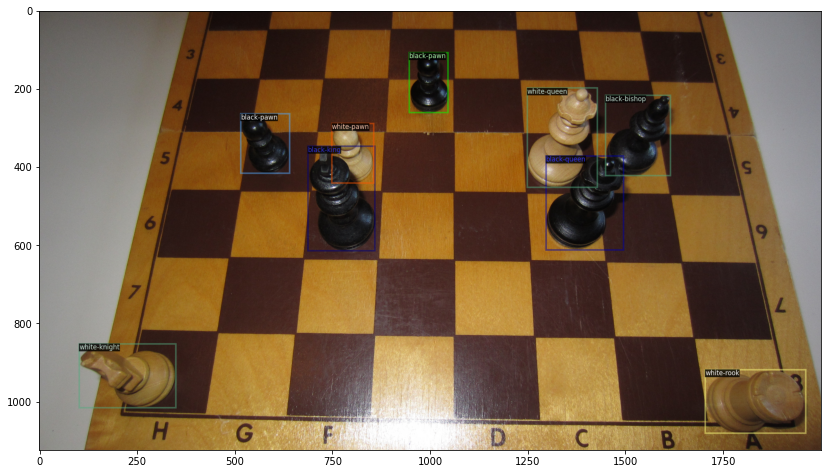

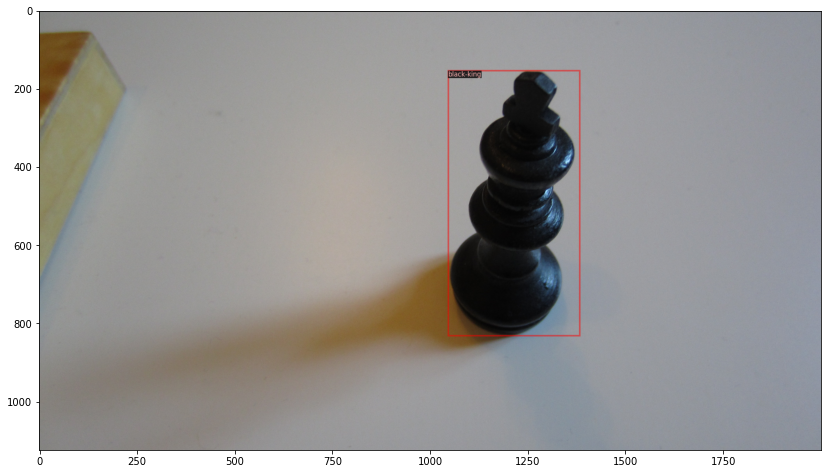

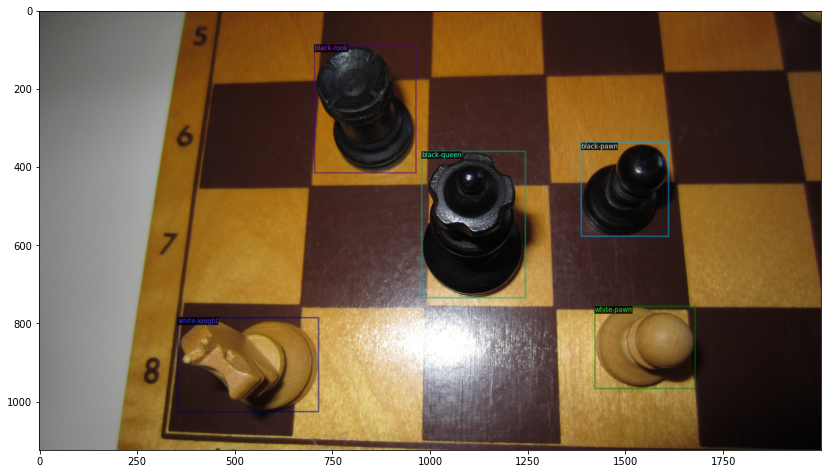

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('chess_piece_dataset')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=chess_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("chess_piece_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 500
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, enough for this dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12  
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()